## Sumador de tres bits:

In [ ]:
!pip install qiskit

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
import qiskit

In [ ]:
def create_circ(num:"string"): #Si se quiere colocar hadamard se debe colocar "h" seguido de los qubits, ej "h12", en caso de no usar hadamard colocar el binario a usar
                               #Ej: "010"
    #Creacion circuito y codificacion
    qr = qiskit.QuantumRegister(5)
    cr = qiskit.ClassicalRegister(2)
    circ = QuantumCircuit(qr,cr)
    if "h" in num:
        for i in [0,1,2]:
            if str(i) in num:
                circ.h(i)
    else:
        j = 0
        for i in num:
            if i == "1":
                circ.x(j)
            j+=1
    circ.x(4)
    circ.barrier()
    circ.fredkin(control_qubit=0,target_qubit1=3,target_qubit2=4)
    circ.fredkin(control_qubit=1,target_qubit1=3,target_qubit2=4)
    circ.fredkin(control_qubit=2,target_qubit1=3,target_qubit2=4)
    circ.fredkin(control_qubit=3,target_qubit1=2,target_qubit2=4)
    circ.fredkin(control_qubit=1,target_qubit1=2,target_qubit2=4)
    circ.barrier()
    circ.measure([2,3],[0,1])
    return circ


In [ ]:
circ = create_circ("h02")
circ.draw()

┌───┐ ░                 ░       
q0_0: ┤ H ├─░──■──────────────░───────
      └───┘ ░  │              ░       
q0_1: ──────░──┼──■────────■──░───────
      ┌───┐ ░  │  │        │  ░ ┌─┐   
q0_2: ┤ H ├─░──┼──┼──■──X──X──░─┤M├───
      └───┘ ░  │  │  │  │  │  ░ └╥┘┌─┐
q0_3: ──────░──X──X──X──■──┼──░──╫─┤M├
      ┌───┐ ░  │  │  │  │  │  ░  ║ └╥┘
q0_4: ┤ X ├─░──X──X──X──X──X──░──╫──╫─
      └───┘ ░                 ░  ║  ║ 
c0: 2/═══════════════════════════╩══╩═
                                 0  1

In [ ]:
from qiskit import execute, Aer

# Crear un backend simulado
backend = Aer.get_backend('qasm_simulator')

# Ejecutar el circuito en el backend
job = execute(circ, backend, shots=1)

# Obtener los resultados de la ejecución
result = job.result()

# Obtener el diccionario de conteos de las mediciones
counts_1 = result.get_counts()

print(counts_1)

{'00': 1}


Este print {'10000': 1} significa que, en una ejecución del circuito, se obtuvo el resultado de medición '10000' una vez. Esto indica que en esa ejecución particular, los cinco qubits medidos tenían un estado final de '10000'.

Simulación de diferentes tipos de errores y ver cómo afectan a una variedad de circuitos cuánticos más complejos, en este caso el resultado de un circuito que implementa el algoritmo de Deutch Jozsa.
(El ruido no solo es aplicado a la medida, sino también a las puertas del circuito).

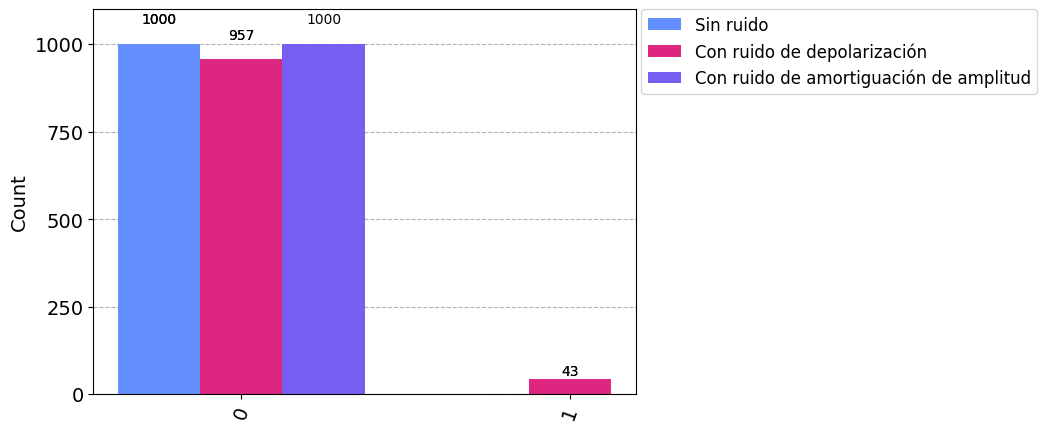

In [ ]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error

# Este es el oráculo para una función constante
def oraculo_constante(circuito):
    # Definimos una función llamada 'oraculo_constante' que toma un circuito como argumento
    circuito.h(1) #le aplicamos hadamard al qubit 1 del circuito
    return circuito

# Esta es la parte del algoritmo de Deutsch-Jozsa
def deutsch_jozsa(circuito):
    circuito.x(1)  # Aplicamos una puerta X al qubit 1 del circuito
    circuito.h([0, 1])   # Aplicamos una puerta Hadamard a los qubits 0 y 1 del circuito


    circuito = oraculo_constante(circuito)

    # Hadamard y medimos el primer qubit
    circuito.h(0)   # Aplicamos una puerta Hadamard al qubit 0 del circuito
    circuito.measure([0], [0])  # Medimos el qubit 0 y almacenamos el resultado en el bit clásico 0


    return circuito

# Se crea el circuito y se aplica el algoritmo
circuito = QuantumCircuit(2, 1) # Creamos un circuito cuántico con 2 qubits y 1 bit clásico
circuito = deutsch_jozsa(circuito) # Llamamos a la función 'deutsch_jozsa' pasando el circuito como argumento


# modelos de ruido
prob_error = 0.1 #Esta variable determina la probabilidad de que ocurra un error en las compuertas cuánticas durante la simulación con ruido.
noise_model_dep = NoiseModel() #Este objeto servirá como modelo de ruido para simular errores de depolarización en las compuertas cuánticas.
error_gate_dep = depolarizing_error(prob_error, 1) # Esta función recibe dos argumentos: la probabilidad de error (prob_error) y la dimensión del espacio de Hilbert afectado por el error (en este caso, 1 qubit).
noise_model_dep.add_all_qubit_quantum_error(error_gate_dep, ['u1', 'u2', 'u3', 'h', 'x', 'measure'])
#se añade la posibilidad de que ocurran errores de depolarización en las compuertas de rotación (u1, u2, u3), la puerta Hadamard (h), la puerta X (x), y la operación de medición (measure).

noise_model_amp = NoiseModel()
error_gate_amp = amplitude_damping_error(prob_error)
noise_model_amp.add_all_qubit_quantum_error(error_gate_amp, ['u1', 'u2', 'u3', 'h', 'x', 'measure'])
#se añade la posibilidad de que ocurran errores de amortiguación de amplitud en las compuertas de rotación (u1, u2, u3), la puerta Hadamard (h), la puerta X (x) y la operación de medición (measure).
#El error de amortiguación de amplitud es un tipo de ruido que representa la pérdida de energía del sistema cuántico, lo que puede llevar a errores en la amplitud de los estados cuánticos.


# Ejecutamos el circuito con y sin ruido
simulator = Aer.get_backend('qasm_simulator') ## Creamos un simulador cuántico utilizando el backend 'qasm_simulator' de Qiskit
job = execute(circuito, simulator, shots=1000) # Ejecutamos el circuito en el simulador sin ruido y realizamos 1000 pruebas
result = job.result() #resultado de la ejecución del circuito
counts = result.get_counts(circuito) # Obtenemos los resultados de la medición y los almacenamos en 'counts'

job_noise_dep = execute(circuito, simulator, shots=1000, noise_model=noise_model_dep) #Ejecutamos el circuito en el simulador con el modelo de ruido de depolarización y realizamos 1000 pruebas
result_noise_dep = job_noise_dep.result()
counts_noise_dep = result_noise_dep.get_counts(circuito)

job_noise_amp = execute(circuito, simulator, shots=1000, noise_model=noise_model_amp) # Ejecutamos el circuito en el simulador con el modelo de ruido de amortiguación de amplitud y realizamos 1000 pruebas
result_noise_amp = job_noise_amp.result()
counts_noise_amp = result_noise_amp.get_counts(circuito)

# Histograma de resultados
plot_histogram([counts, counts_noise_dep, counts_noise_amp], legend=['Sin ruido', 'Con ruido de depolarización', 'Con ruido de amortiguación de amplitud'])



A continuación se simulará ruido en el circuito de suma de bits con ayuda del segundo algoritmo:

In [ ]:
def apply_noise(circuit, noise_model):
    # Ejecutar el circuito con el modelo de ruido
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, shots=1000, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

In [ ]:
counts_noise_dep_2 = apply_noise(circ, noise_model_dep)
counts_noise_amp_2 = apply_noise(circ, noise_model_amp)

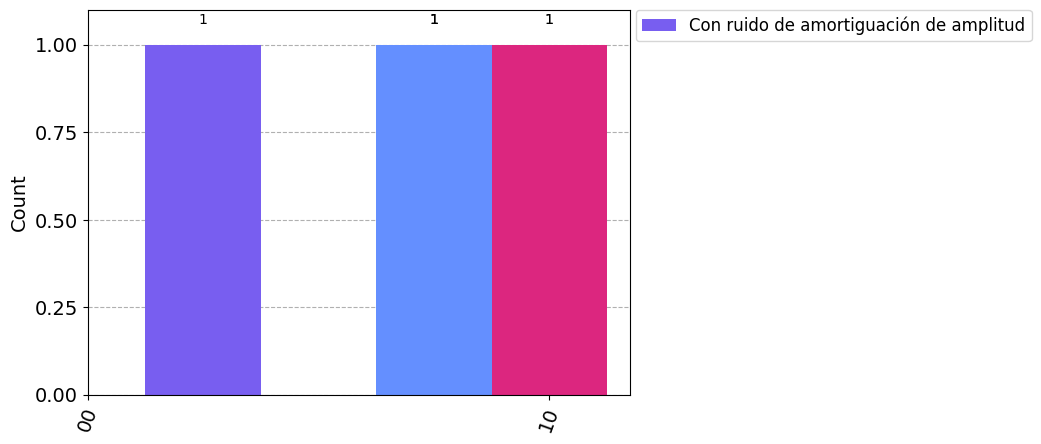

In [ ]:
plot_histogram([counts_1, counts_noise_dep_2, counts_noise_amp_2], legend=['Sin ruido', 'Con ruido de depolarización', 'Con ruido de amortiguación de amplitud'])


In [ ]:
circ2 = create_circ("011")

In [ ]:
circ2.draw()

░                 ░       
q15_0: ──────░──■──────────────░───────
       ┌───┐ ░  │              ░       
q15_1: ┤ X ├─░──┼──■────────■──░───────
       ├───┤ ░  │  │        │  ░ ┌─┐   
q15_2: ┤ X ├─░──┼──┼──■──X──X──░─┤M├───
       └───┘ ░  │  │  │  │  │  ░ └╥┘┌─┐
q15_3: ──────░──X──X──X──■──┼──░──╫─┤M├
       ┌───┐ ░  │  │  │  │  │  ░  ║ └╥┘
q15_4: ┤ X ├─░──X──X──X──X──X──░──╫──╫─
       └───┘ ░                 ░  ║  ║ 
 c1: 2/═══════════════════════════╩══╩═
                                  0  1

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circ2, backend, shots=1000)
result = job.result()
counts_1 = result.get_counts()

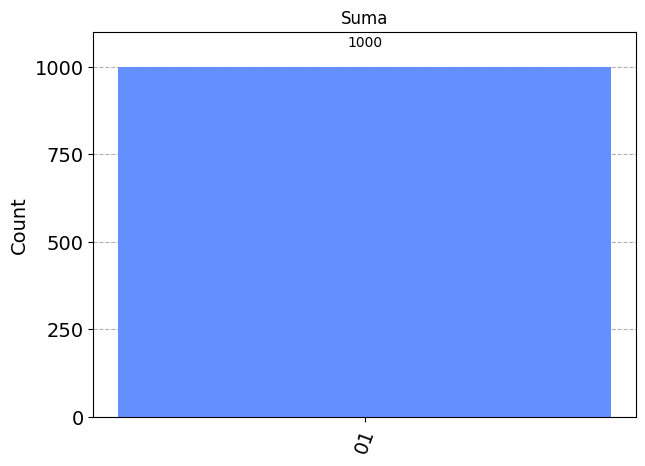

In [ ]:
plot_histogram(counts_1, title='Suma')

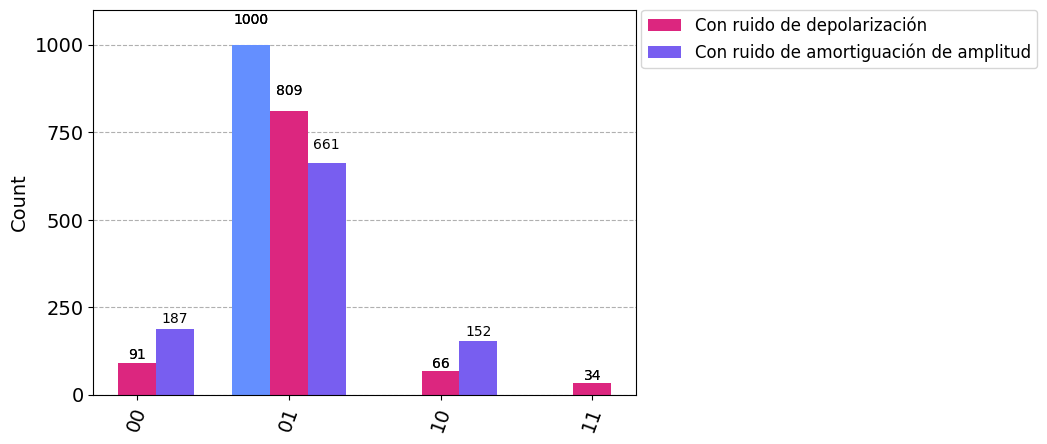

In [ ]:
counts_noise_dep_2 = apply_noise(circ2, noise_model_dep)
counts_noise_amp_2 = apply_noise(circ2, noise_model_amp)
plot_histogram([counts_1, counts_noise_dep_2, counts_noise_amp_2], legend=['Sin ruido', 'Con ruido de depolarización', 'Con ruido de amortiguación de amplitud'])

In [ ]:
circ2 = create_circ("h1")
circ2.draw()

░                 ░       
q28_0: ──────░──■──────────────░───────
       ┌───┐ ░  │              ░       
q28_1: ┤ H ├─░──┼──■────────■──░───────
       └───┘ ░  │  │        │  ░ ┌─┐   
q28_2: ──────░──┼──┼──■──X──X──░─┤M├───
             ░  │  │  │  │  │  ░ └╥┘┌─┐
q28_3: ──────░──X──X──X──■──┼──░──╫─┤M├
       ┌───┐ ░  │  │  │  │  │  ░  ║ └╥┘
q28_4: ┤ X ├─░──X──X──X──X──X──░──╫──╫─
       └───┘ ░                 ░  ║  ║ 
 c2: 2/═══════════════════════════╩══╩═
                                  0  1

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circ2, backend, shots=1000)
result = job.result()
counts_1 = result.get_counts()

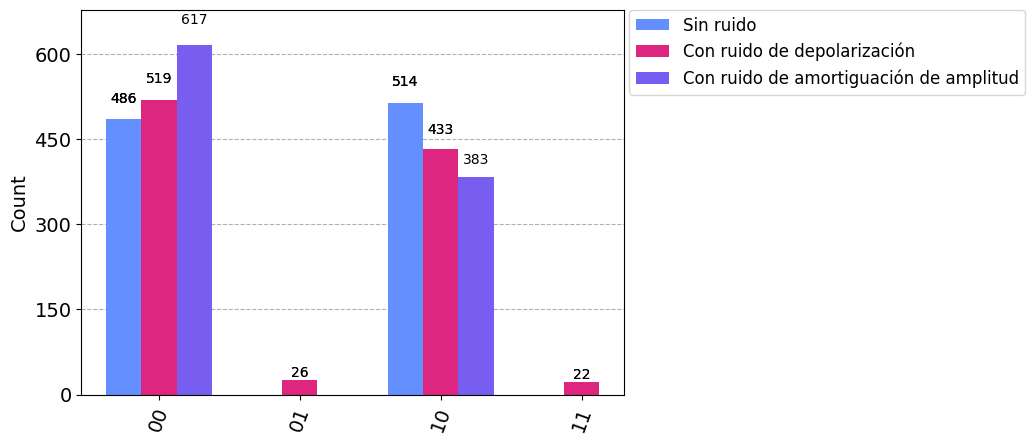

In [ ]:
counts_noise_dep_2 = apply_noise(circ2, noise_model_dep)
counts_noise_amp_2 = apply_noise(circ2, noise_model_amp)
plot_histogram([counts_1, counts_noise_dep_2, counts_noise_amp_2], legend=['Sin ruido', 'Con ruido de depolarización', 'Con ruido de amortiguación de amplitud'])